In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import plot.viz_sequence as viz_sequence
import pyBigWig
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import scipy.stats
import json
import tqdm
import h5py
import sklearn.metrics
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define paths for the model and data of interest

In [3]:
model_type = "binary"

In [4]:
# Shared paths/constants
raw_data_base_path = "/users/amtseng/att_priors/data/raw/"
interim_data_base_path = "/users/amtseng/att_priors/data/interim/"
proc_data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
results_path = "/users/amtseng/att_priors/results/"
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"

In [5]:
# K562
condition_name = "K562"
files_spec_path = os.path.join(proc_data_base_path, "ENCODE_DNase/%s/config/K562/K562_training_paths.json" % model_type)
num_tasks = 1
num_strands = 1
if model_type == "profile":
    controls = "shared"
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor

task_index = None
footprints_paths = [os.path.join(proc_data_base_path, "DNase_footprints/K562_tencol.bed.gz")]
noprior_model_path = os.path.join(model_base_path, "K562/28/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior/9/model_ckpt_epoch_8.pt")

tf_names = ["CTCF", "GATA2", "JUN", "KLF1"]
fimo_results_paths = [
    os.path.join(results_path, "K562_motifs/FIMO_chr1_calls/motif%d_fimo_out/fimo.tsv" % i) for i in range(1, 5)
]
chipseq_peak_paths = [
    os.path.join(results_path, "K562_motifs/peaks_of_matched_tfs/motif%d_peaks.bed.gz" % i) for i in range(1, 5)
]

In [6]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [7]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [8]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Import footprints, ChIP-seq peaks, and motif predictions

In [9]:
footprints = [
    pd.read_csv(
        path, sep="\t", header=None,
        names=[
            "chrom", "peak_start", "peak_end", "name", "score", "strand",
            "signal", "pval", "qval", "summit_offset"
        ]
    ) for path in footprints_paths
]
footprints = pd.concat(footprints)
footprints = footprints[footprints["chrom"].isin(chrom_set)]

In [10]:
fimo_results = [
    pd.read_csv(
        path, sep="\t", header=0, index_col=None
    ).dropna() for path in fimo_results_paths
]
for table in fimo_results:
    table["start"] = table["start"].astype(int)
    table["stop"] = table["stop"].astype(int)

In [11]:
chipseq_peaks = [
    pd.read_csv(
        path, sep="\t", header=None,
        names=[
            "chrom", "peak_start", "peak_end", "name", "score", "strand",
            "signal", "pval", "qval", "summit_offset"
        ]
    ) for path in chipseq_peak_paths
]

In [12]:
fimo_results_limited = [
    table.sort_values("q-value").reset_index(drop=True)[:int(0.1 * len(table))]
    for table in fimo_results
]

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model

In [13]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_set = data_loading.get_positive_profile_coords(
        files_spec_path, task_ind=task_index, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_set = data_loading.get_positive_binary_bins(
        files_spec_path, task_ind=task_index, chrom_set=chrom_set
    )

### Compute importances

In [14]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [15]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls,
            task_index=task_index
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length, task_index=task_index
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [16]:
num_samples = 1000
rng = np.random.RandomState(20200318)
sample = pos_set[rng.choice(len(pos_set), size=num_samples, replace=False)]

In [17]:
# Get coordinates for the sample
if model_type == "profile":
    # For profile models, add a random jitter to avoid center-bias
    jitters = np.random.randint(-128, 128 + 1, size=len(sample))
    sample[:, 1] = sample[:, 1] + jitters
    sample[:, 2] = sample[:, 2] + jitters
    sample_coords = sample
else:
    sample_coords = input_func(sample)[2]

In [18]:
# Compute the importance scores and 1-hot seqs
imp_type = ("DeepSHAP scores", "input gradients")[0]
imp_func = compute_shap_scores if imp_type == "DeepSHAP scores" else compute_gradients
noprior_imp_scores, sample_input_seqs = imp_func(
    noprior_model, sample
)
prior_imp_scores, _ = imp_func(
    prior_model, sample
)

In [19]:
# Pad the coordinates on both sides symmetrically to make them `input_length` 
centers = (sample_coords[:, 1] + sample_coords[:, 2]) // 2
starts = centers - (input_length // 2)
ends = starts + input_length
sample_coords[:, 1] = starts
sample_coords[:, 2] = ends

586 288855
Without priors:


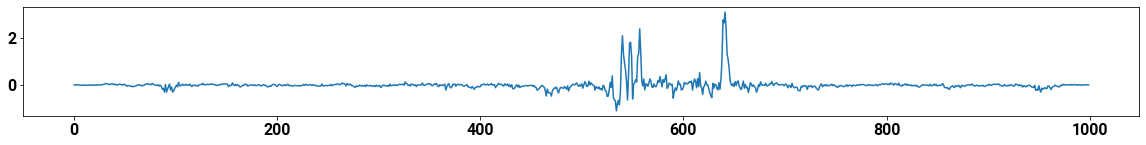

With priors:


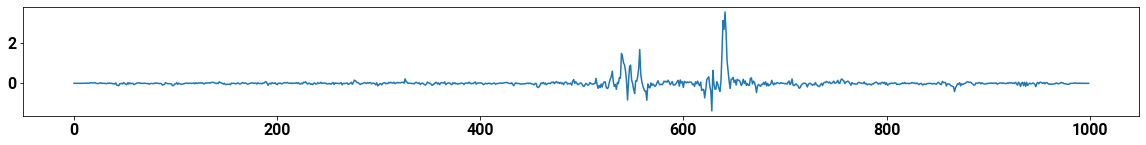

459 435654
Without priors:


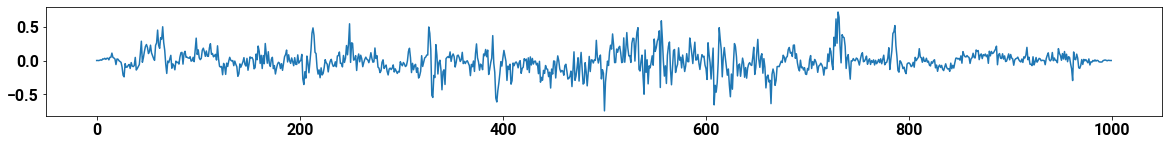

With priors:


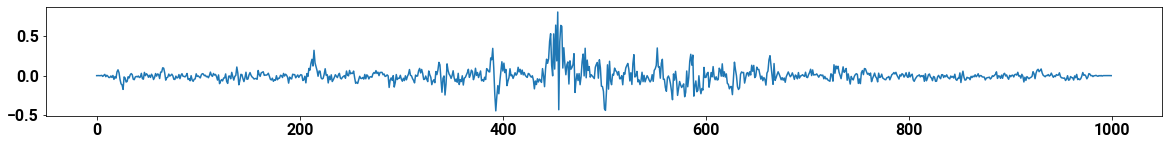

696 3223318
Without priors:


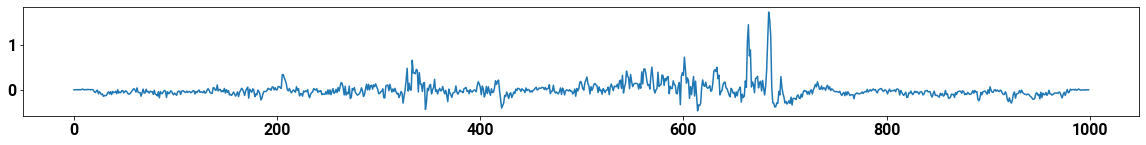

With priors:


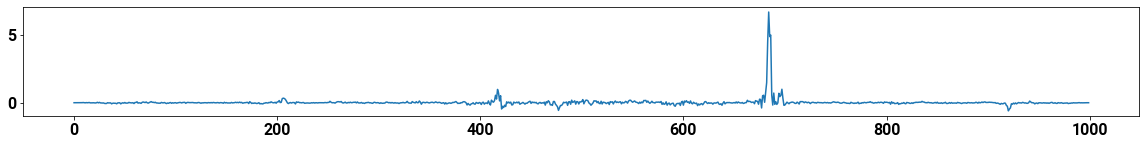

In [20]:
# Plot out a few examples
for i in np.random.choice(num_samples, size=3, replace=False):
    print(i, sample[i])
    print("=========================")
    print("Without priors:")
    plt.figure(figsize=(20, 2))
    plt.plot(np.sum(noprior_imp_scores[i] * sample_input_seqs[i], axis=1))
    plt.show()
    print("With priors:")
    plt.figure(figsize=(20, 2))
    plt.plot(np.sum(prior_imp_scores[i] * sample_input_seqs[i], axis=1))
    plt.show()

### Quantify agreement of importances with footprints using overlap
In each importance score track (over the entire input region), do the importances tend to be elevated more in known footprints?

In [21]:
def compute_footprint_overlap_amount(coords, score_tracks, footprints):
    """
    From an N x 3 object array of coordinates, a parallel N x I x 4 array
    of score tracks, and a table of imported footprints, this function computes
    and returns the overlap amount for each of the N examples, where the overlap
    for an example is the fraction of score magnitudes in its track that fall
    within a footprint. An overlap will be NaN if there are no footprints in the
    coordinate. Returns an N-array.
    """
    score_tracks = np.abs(score_tracks)  # Take absolute value of score tracks
    overlaps = np.empty(len(coords))
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        # Filter down the set of footprints to only those that overlap with the
        # coordinate
        fps = footprints[
            (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
            (start <= footprints["peak_end"])
        ]
        mask = np.zeros(end - start, dtype=bool)
        intervals = fps[["peak_start", "peak_end"]].values - start
        for interval in intervals:
            mask[interval[0]:interval[1]] = True
        if not np.sum(mask):
            overlaps[i] = np.nan
        else:
            overlaps[i] = np.sum(score_tracks[i][mask]) / np.sum(score_tracks[i])
    return overlaps

In [22]:
noprior_imp_fp_overlaps = compute_footprint_overlap_amount(
    sample_coords, noprior_imp_scores * sample_input_seqs, footprints
)
prior_imp_fp_overlaps = compute_footprint_overlap_amount(
    sample_coords, prior_imp_scores * sample_input_seqs, footprints
)

# Remove the NaNs, which is where no footprint was in the coordinate
noprior_imp_fp_overlaps = noprior_imp_fp_overlaps[np.isfinite(noprior_imp_fp_overlaps)]
prior_imp_fp_overlaps = prior_imp_fp_overlaps[np.isfinite(prior_imp_fp_overlaps)]

Average score without priors: 0.230945
Average score with priors: 0.249527
One-sided Wilcoxon test: W = 277482.000000, p = 0.000000


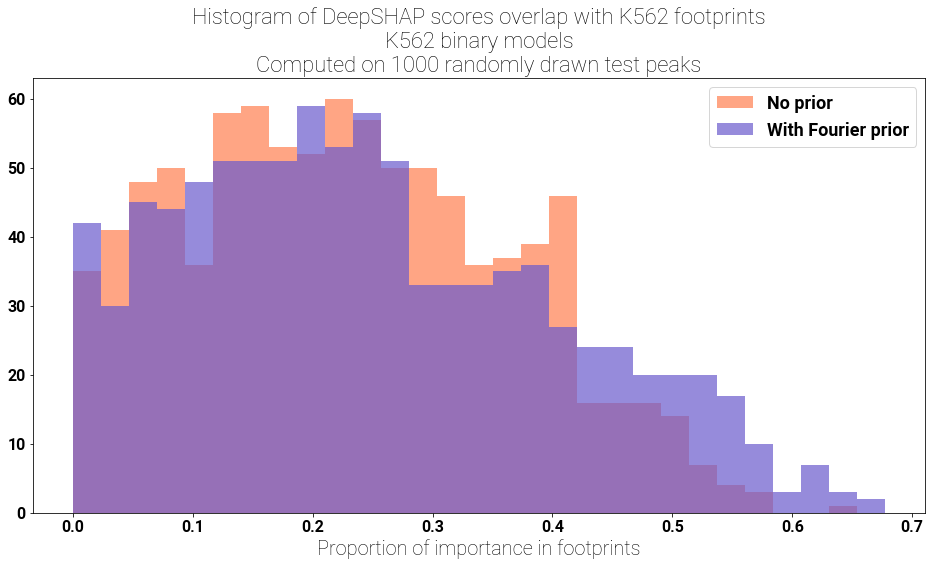

In [23]:
bin_num = 30
all_vals = np.concatenate([noprior_imp_fp_overlaps, prior_imp_fp_overlaps])
bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(noprior_imp_fp_overlaps, bins=bins, color="coral", label="No prior", alpha=0.7)
ax.hist(prior_imp_fp_overlaps, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
plt.legend()
title = "Histogram of %s overlap with %s footprints" % (imp_type, condition_name)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nComputed on %d randomly drawn test peaks" % num_samples
plt.title(title)
plt.xlabel("Proportion of importance in footprints")

print("Average score without priors: %f" % np.nanmean(noprior_imp_fp_overlaps))
print("Average score with priors: %f" % np.nanmean(prior_imp_fp_overlaps))
w, p = scipy.stats.wilcoxon(prior_imp_fp_overlaps, noprior_imp_fp_overlaps, alternative="greater")
print("One-sided Wilcoxon test: W = %f, p = %f" % (w, p))

Text(0, 0.5, 'Proportion of importance in footprints with Fourier prior')

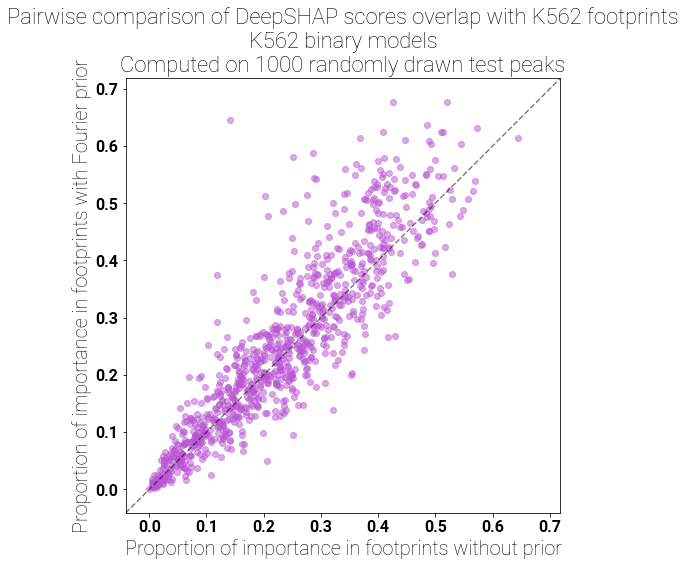

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(noprior_imp_fp_overlaps, prior_imp_fp_overlaps, color="mediumorchid", alpha=0.5)
title = "Pairwise comparison of %s overlap with %s footprints" % (imp_type, condition_name)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nComputed on %d randomly drawn test peaks" % num_samples
plt.title(title)
limits = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(limits, limits, "--", alpha=0.5, color="black")
ax.set_aspect("equal")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.xlabel("Proportion of importance in footprints without prior")
plt.ylabel("Proportion of importance in footprints with Fourier prior")

### Quantify agreement of importance windows with footprints using ranks
Rank all of the windows by importance; do the windows at the top tend to overlap with footprints?

In [25]:
def compute_single_footprint_overlap_mask(chrom, start, end, footprints):
    """
    Given a coordinate, returns a boolean mask for that coordinate
    for which bases lie within a footprint
    """
    mask = np.zeros(end - start, dtype=bool)
    for peak_bed in peak_beds:
        rows = footprints[
            (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
            (start <= footprints["peak_end"])
        ]
        intervals = rows[["peak_start", "peak_end"]].values - start
        for interval in intervals:
            mask[interval[0]:interval[1]] = True
    return mask

In [26]:
def compute_single_footprint_overlap_mask(chrom, start, end, footprints):
    """
    Given a coordinate, returns a boolean mask for that coordinate
    for which bases lie within a footprint
    """
    mask = np.zeros(end - start, dtype=bool)
    rows = footprints[
        (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
        (start <= footprints["peak_end"])
    ]
    intervals = rows[["peak_start", "peak_end"]].values - start
    for interval in intervals:
        mask[interval[0]:interval[1]] = True
    return mask

def compute_footprint_overlap_mask(coords, footprints):
    """
    Given a sample of N coordinates or bins, extracts a boolean mask
    denoting which locations in each sample overlap a footprint.
    Returns an N x I boolean array, where each subarray is a boolean mask
    for which bases in that coordinate lie within a footprint.
    """
    masks = []
    for coord in tqdm.notebook.tqdm(coords):
        # Pad to profile length
        masks.append(compute_single_footprint_overlap_mask(coord[0], coord[1], coord[2], footprints))
    return np.stack(masks, axis=0)

In [27]:
def compute_windowed_footprint_overlap_mask(scores, one_hot_seqs, seq_footprint_masks, window_size=10):
    """
    Windowing by `window_size`, computes the total importance magnitude for the
    actual importance in each window, and identifies which windows overlap a footprint.
    Returns a boolean NumPy array denoting which windows overlap a peak, sorted in
    descending order of window importance, and the indices of each window. This requires
    a mask of whether or not each base in each input sequence overlaps a footprint,
    computed by `compute_footprint_overlap_mask`.
    """
    num_samples = len(scores)
    all_window_imps, all_footprint_masks = [], []
    all_window_inds = []
    for i in tqdm.notebook.trange(num_samples):
        score_track = np.sum(np.abs(scores[i] * one_hot_seqs[i]), axis=1)  # Actual importance
        num_windows = len(score_track) - window_size + 1
        
        # Compute windowed peak mask
        window_locs = np.arange(num_windows) + ((len(score_track) - num_windows) / 2)
        windowed_footprint_mask = seq_footprint_masks[i][window_locs.astype(int)]
        
        # Compute sum of importance in each window
        importances = np.empty(num_windows)
        for j in range(num_windows):
            importances[j] = np.sum(score_track[j : j + window_size])
            all_window_inds.append([i, j])
        
        all_window_imps.append(importances)
        all_footprint_masks.append(windowed_footprint_mask)
    
    window_imps, all_footprint_masks = np.concatenate(all_window_imps), np.concatenate(all_footprint_masks)
    all_window_inds = np.stack(all_window_inds)
    return all_footprint_masks[np.flip(np.argsort(window_imps))], all_window_inds[np.flip(np.argsort(window_imps))]

In [28]:
def normed_rank_enrichment(ordered_mask):
    """
    From a binary mask array (in order from best to worst thresholds), computes
    the rank enrichment at each threshold. Specifically, this computes a
    normalized CDF of how many 1s are seen in the first k instances.
    """
    cdf = np.cumsum(ordered_mask)
    # To normalize, divide by the expectation if there all 1s were spread
    # out evenly across the instances
    expectation = np.sum(ordered_mask) / len(ordered_mask) * np.arange(1, len(cdf) + 1)
    return cdf / expectation

In [29]:
window_size = 1

In [30]:
footprint_masks = compute_footprint_overlap_mask(sample_coords, footprints)
noprior_window_overlap_mask, noprior_windows = compute_windowed_footprint_overlap_mask(
    noprior_imp_scores, sample_input_seqs, footprint_masks, window_size=window_size
)
prior_window_overlap_mask, prior_windows = compute_windowed_footprint_overlap_mask(
    prior_imp_scores, sample_input_seqs, footprint_masks, window_size=window_size
)
noprior_window_overlap_cdf = normed_rank_enrichment(noprior_window_overlap_mask)
prior_window_overlap_cdf = normed_rank_enrichment(prior_window_overlap_mask)

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


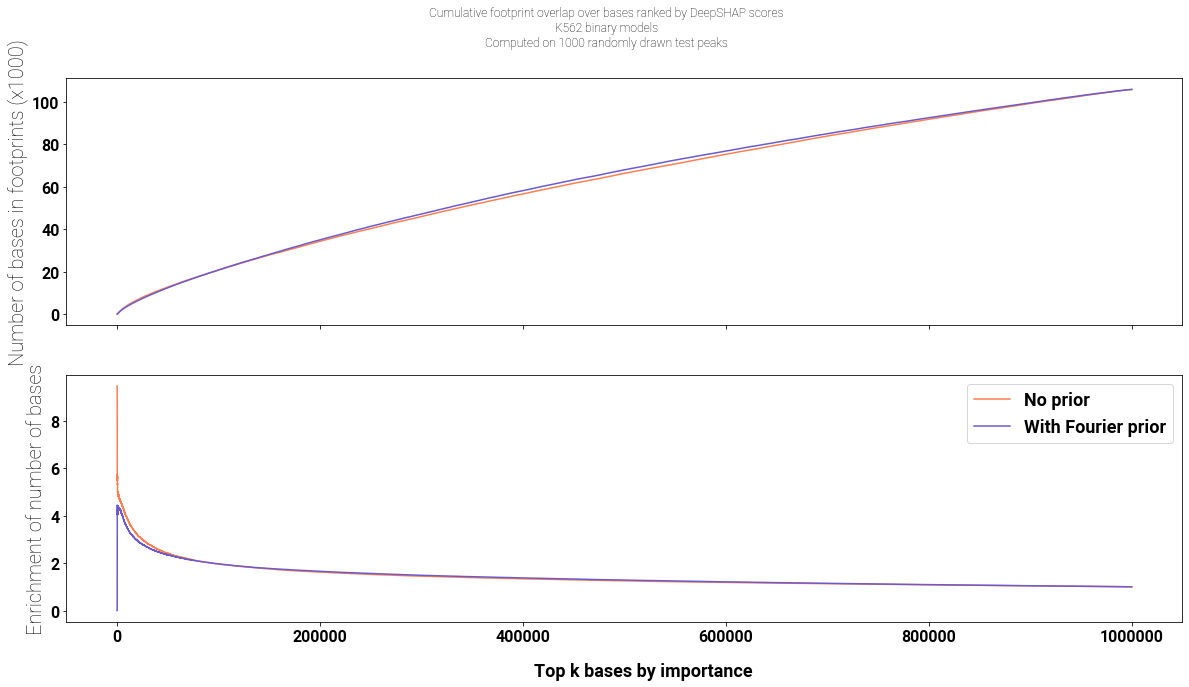

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
title = "Cumulative footprint overlap over bases ranked by %s" % imp_type
title += "\n%s %s models" % (condition_name, model_type)
title += "\nComputed on %d randomly drawn test peaks" % num_samples
fig.suptitle(title)
ax[0].plot(np.cumsum(noprior_window_overlap_mask), label="No prior", color="coral")
ax[0].plot(np.cumsum(prior_window_overlap_mask), label="With Fourier prior", color="slateblue")
ax[0].set_ylabel("Number of bases in footprints (x1000)")
ax[0].set_yticklabels((ax[0].get_yticks() / 1000).astype(int))
ax[1].plot(noprior_window_overlap_cdf, label="No prior", color="coral")
ax[1].plot(prior_window_overlap_cdf, label="With Fourier prior", color="slateblue")
ax[1].set_ylabel("Enrichment of number of bases")
fig.text(0.45, 0.05, "Top k bases by importance", fontsize=18)
plt.legend()

In [32]:
noprior_precis, noprior_recall, _ = sklearn.metrics.precision_recall_curve(
    noprior_window_overlap_mask.astype(int),
    np.flip(np.arange(len(noprior_window_overlap_mask))) / len(noprior_window_overlap_mask)
)
prior_precis, prior_recall, _ = sklearn.metrics.precision_recall_curve(
    prior_window_overlap_mask.astype(int),
    np.flip(np.arange(len(prior_window_overlap_mask))) / len(prior_window_overlap_mask)
)

auPRC without priors: 0.174813
auPRC with priors: 0.172828


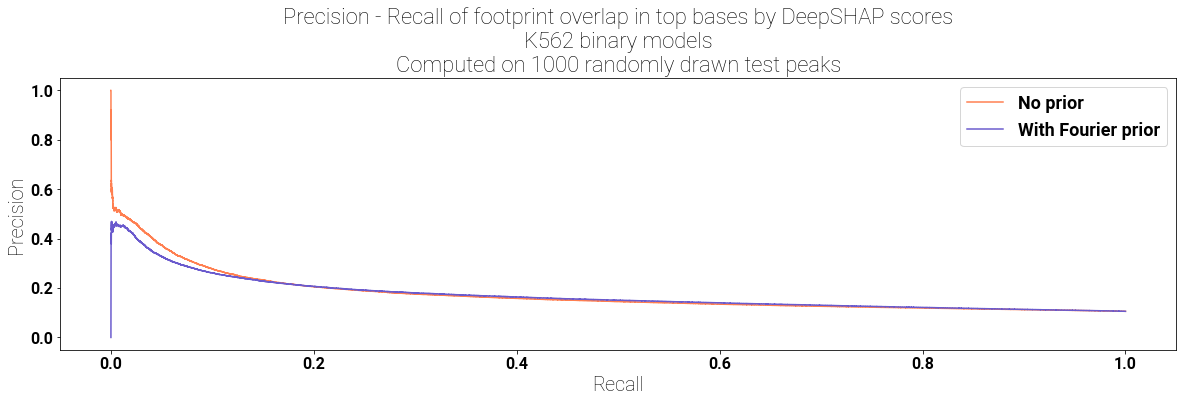

In [33]:
fig, ax = plt.subplots(figsize=(20, 5))
title = "Precision - Recall of footprint overlap in top bases by %s" % imp_type
title += "\n%s %s models" % (condition_name, model_type)
title += "\nComputed on %d randomly drawn test peaks" % num_samples
plt.title(title)
plt.plot(noprior_recall[:-1], noprior_precis[:-1], color="coral", label="No prior")
plt.plot(prior_recall[:-1], prior_precis[:-1], color="slateblue", label="With Fourier prior")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

print("auPRC without priors: %f" % sklearn.metrics.auc(noprior_recall[:-1], noprior_precis[:-1]))
print("auPRC with priors: %f" % sklearn.metrics.auc(prior_recall[:-1], prior_precis[:-1]))

### Obtain motif instance calls
Subset to the coordinates we are looking at currently

In [34]:
def get_motif_instances_in_sample(coords, imp_scores, fimo_table):
    """
    From an N x 3 object array of coordinates, and an imported FIMO results
    table, fetches the coordinates of the motif calls that overlap `coord`,
    ordered by total actual importance in `imp_scores`, an N x I x 4 array.
    """
    fimo_table_uniq = fimo_table.drop_duplicates(["sequence_name", "start", "stop"])
    motif_coords, scores = [], []
    for i, coord in tqdm.notebook.tqdm(enumerate(coords), total=len(coords)):
        chrom, start, end = coord
        rows = fimo_table_uniq[
            (fimo_table_uniq["sequence_name"] == chrom) & (fimo_table_uniq["start"] >= start) & \
            (fimo_table_uniq["stop"] <= end)  # Take motif calls that lie entirely in the coordinate
        ]
        for _, row in rows.iterrows():
            motif_coords.append([row["sequence_name"], row["start"], row["stop"]])
            seq_start = row["start"] - start
            seq_end = row["stop"] - end
            scores.append(np.sum(np.abs(imp_scores[i][seq_start:seq_end])))
            
    motif_coords = np.array(motif_coords, dtype=object)
    scores = np.array(scores)
    
    inds = np.flip(np.argsort(scores))
    return motif_coords[inds]

In [35]:
noprior_motif_coords, prior_motif_coords = [], []
for i in range(len(tf_names)):
    noprior_motif_coords.append(
        get_motif_instances_in_sample(
            sample_coords, (noprior_imp_scores * sample_input_seqs), fimo_results[i]
        )
    )
    prior_motif_coords.append(
        get_motif_instances_in_sample(
            sample_coords, (prior_imp_scores * sample_input_seqs), fimo_results[i]
        )
    )

### Quantify agreement of motif instances with footprints using ranks
This is done over all footprints in conjunction.

In [36]:
def compute_footprint_overlap(coords, footprints):
    """
    From an N x 3 object array of coordinates and a table of imported footprints,
    this function determines which coordinates overlap with a footprint.
    Returns a N-array binary mask, denoting which coordinates overlap with a
    footprint.
    """
    mask = np.zeros(len(coords), dtype=int)
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        fps = footprints[
            (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
            (start <= footprints["peak_end"])
        ]
        if len(fps):
            mask[i] = 1
    return mask

In [37]:
noprior_motif_overlap_masks, prior_motif_overlap_masks = [], []
noprior_motif_overlap_cdfs, prior_motif_overlap_cdfs = [], []
for i in range(len(tf_names)):
    noprior_motif_overlap_mask = compute_footprint_overlap(
        noprior_motif_coords[i][:10000], footprints
    )
    prior_motif_overlap_mask = compute_footprint_overlap(
        prior_motif_coords[i][:10000], footprints
    )
    noprior_motif_overlap_cdf = normed_rank_enrichment(noprior_motif_overlap_mask)
    prior_motif_overlap_cdf = normed_rank_enrichment(prior_motif_overlap_mask)
    noprior_motif_overlap_masks.append(noprior_motif_overlap_mask)
    prior_motif_overlap_masks.append(prior_motif_overlap_mask)
    noprior_motif_overlap_cdfs.append(noprior_motif_overlap_cdf)
    prior_motif_overlap_cdfs.append(prior_motif_overlap_cdf)

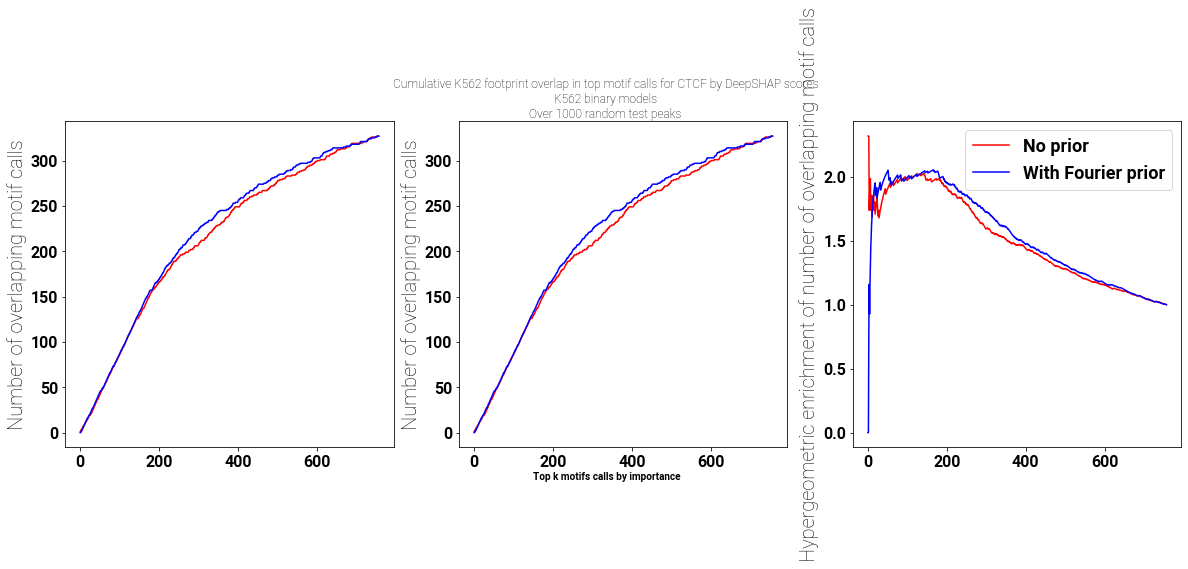

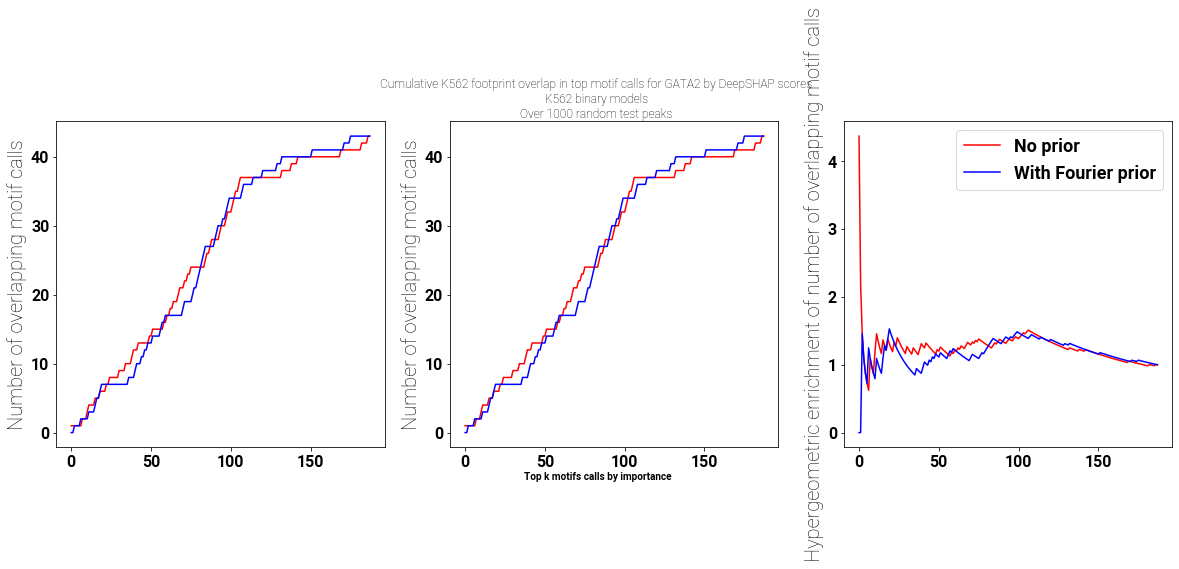

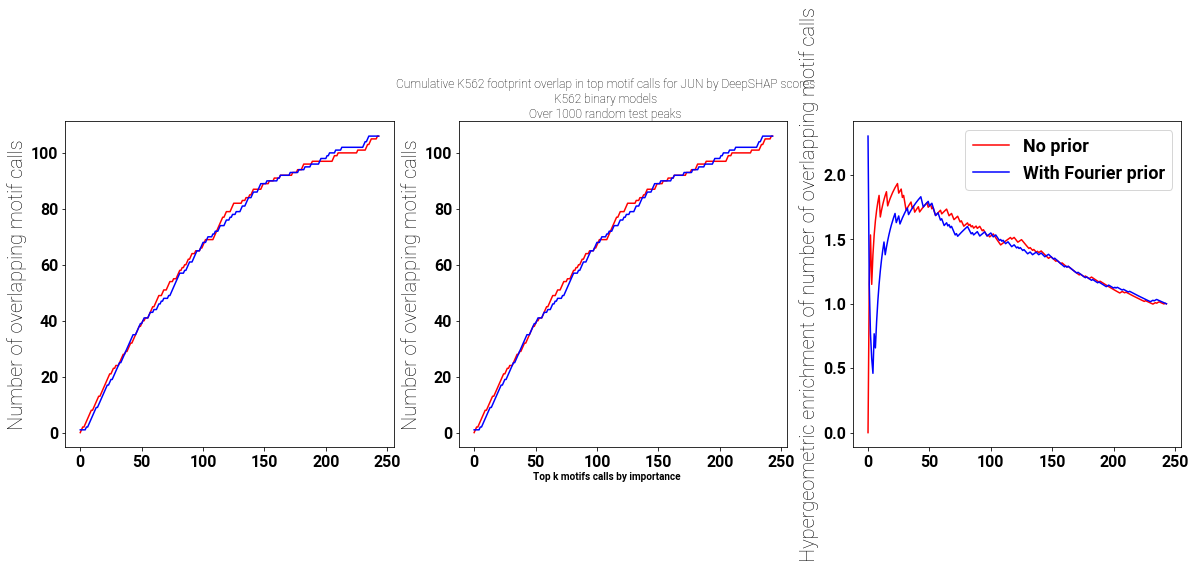

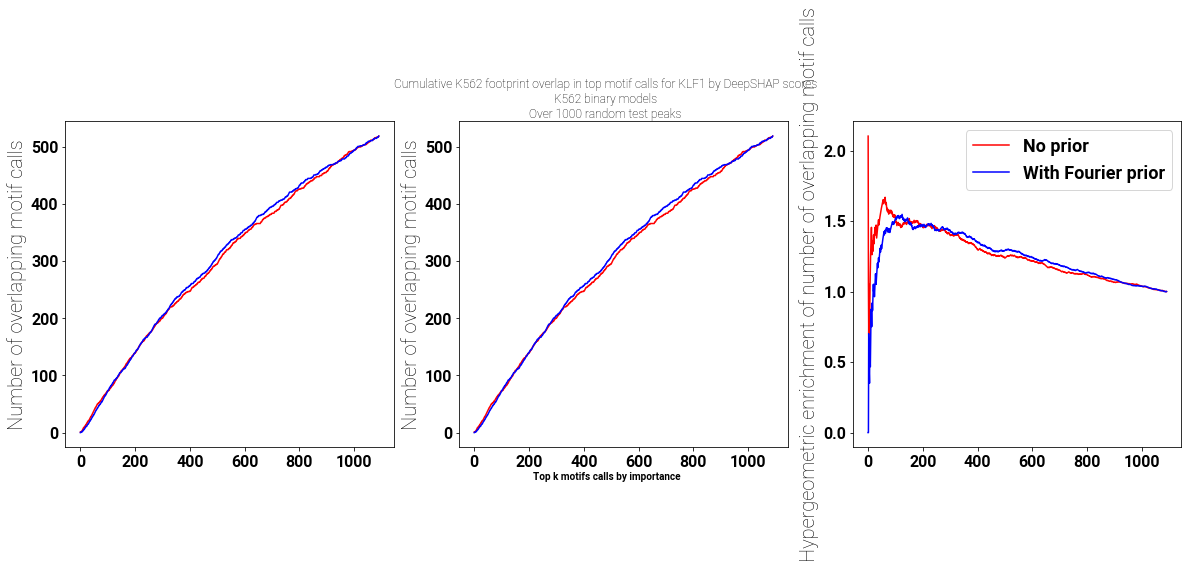

In [38]:
for i in range(len(tf_names)):
    top_limit = 10000
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    title = "Cumulative %s footprint overlap in top motif calls for %s by %s" % (condition_name, tf_names[i], imp_type)
    title += "\n%s %s models" % (condition_name, model_type)
    title += "\nOver %d random test peaks" % len(sample)
    fig.suptitle(title)
    ax[0].plot(np.cumsum(noprior_motif_overlap_masks[i][:top_limit]), label="No prior", color="red")
    ax[0].plot(np.cumsum(prior_motif_overlap_masks[i][:top_limit]), label="With Fourier prior", color="blue")
    ax[0].set_ylabel("Number of overlapping motif calls")
    ax[1].plot(np.cumsum(noprior_motif_overlap_masks[i]), label="No prior", color="red")
    ax[1].plot(np.cumsum(prior_motif_overlap_masks[i]), label="With Fourier prior", color="blue")
    ax[1].set_ylabel("Number of overlapping motif calls")
    ax[2].plot(noprior_motif_overlap_cdfs[i], label="No prior", color="red")
    ax[2].plot(prior_motif_overlap_cdfs[i], label="With Fourier prior", color="blue")
    ax[2].set_ylabel("Hypergeometric enrichment of number of overlapping motif calls")
    fig.text(0.45, 0.05, "Top k motifs calls by importance")
    plt.legend()

In [39]:
noprior_prs, prior_prs = [], []
for i in range(len(tf_names)):
    noprior_prs.append(
        sklearn.metrics.precision_recall_curve(
            noprior_motif_overlap_masks[i].astype(int),
            np.flip(np.arange(len(noprior_motif_overlap_masks[i]))) / len(noprior_motif_overlap_masks[i])
        )
    )
    prior_prs.append(
        sklearn.metrics.precision_recall_curve(
            prior_motif_overlap_masks[i].astype(int),
            np.flip(np.arange(len(prior_motif_overlap_masks[i]))) / len(prior_motif_overlap_masks[i])
        )
    )

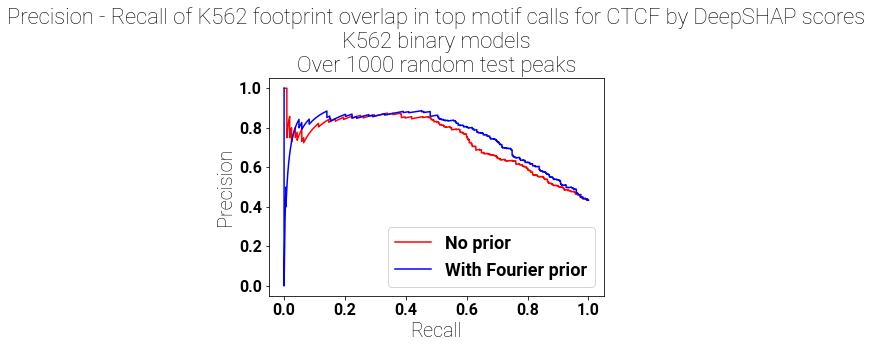

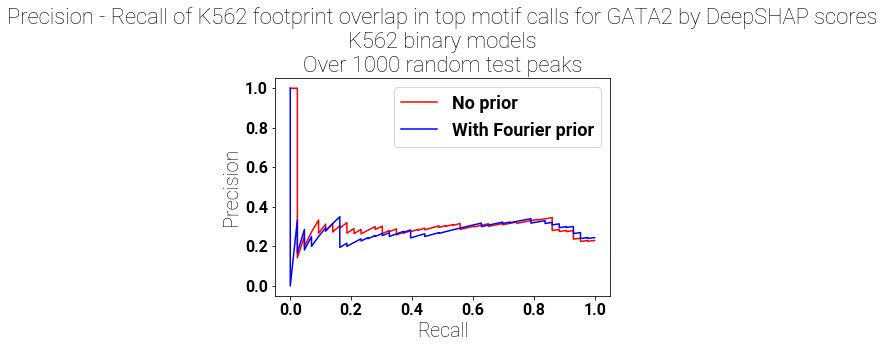

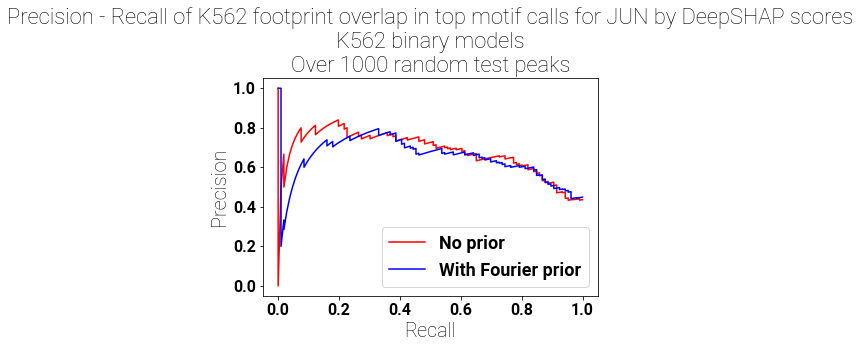

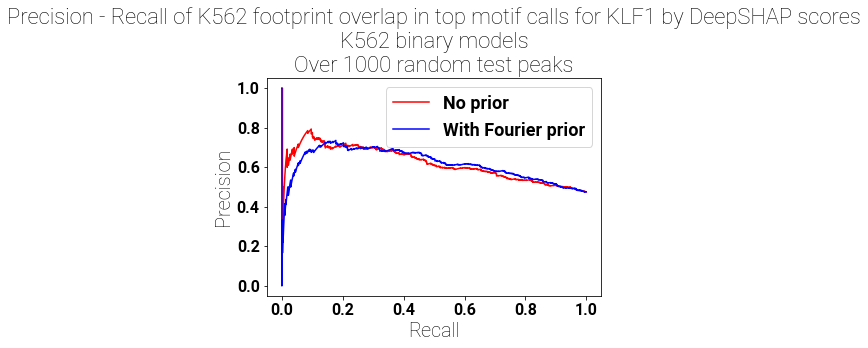

In [40]:
for i in range(len(tf_names)):
    plt.figure()
    title = "Precision - Recall of %s footprint overlap in top motif calls for %s by %s" % (condition_name, tf_names[i], imp_type)
    title += "\n%s %s models" % (condition_name, model_type)
    title += "\nOver %d random test peaks" % len(sample)
    plt.title(title)
    plt.plot(noprior_prs[i][1], noprior_prs[i][0], color="red", label="No prior")
    plt.plot(prior_prs[i][1], prior_prs[i][0], color="blue", label="With Fourier prior")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

### Quantify agreement of motif instances with ChIP-seq peaks using ranks

In [41]:
noprior_motif_overlap_masks, prior_motif_overlap_masks = [], []
noprior_motif_overlap_cdfs, prior_motif_overlap_cdfs = [], []
for i in range(len(tf_names)):
    noprior_motif_overlap_mask = compute_footprint_overlap(
        noprior_motif_coords[i][:10000], chipseq_peaks[i]
    )
    prior_motif_overlap_mask = compute_footprint_overlap(
        prior_motif_coords[i][:10000], chipseq_peaks[i]
    )
    noprior_motif_overlap_cdf = normed_rank_enrichment(noprior_motif_overlap_mask)
    prior_motif_overlap_cdf = normed_rank_enrichment(prior_motif_overlap_mask)
    noprior_motif_overlap_masks.append(noprior_motif_overlap_mask)
    prior_motif_overlap_masks.append(prior_motif_overlap_mask)
    noprior_motif_overlap_cdfs.append(noprior_motif_overlap_cdf)
    prior_motif_overlap_cdfs.append(prior_motif_overlap_cdf)

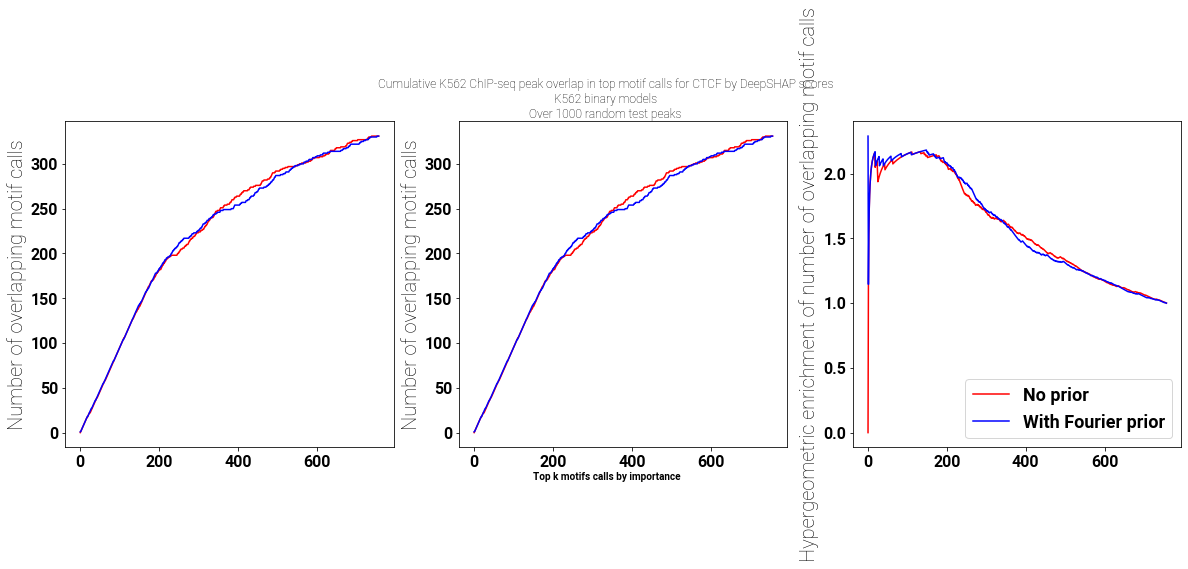

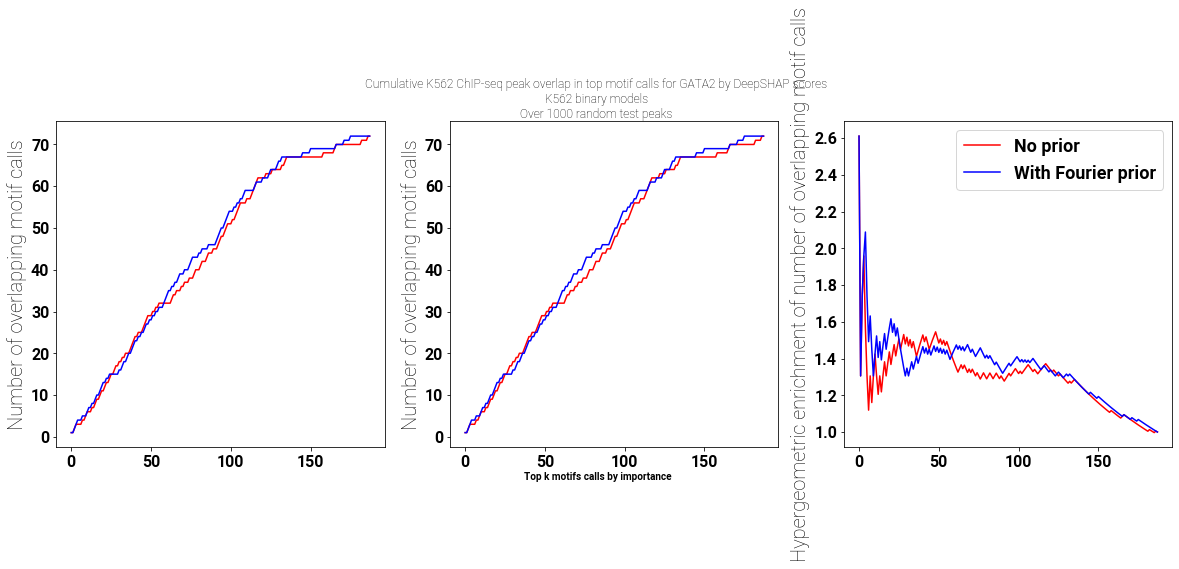

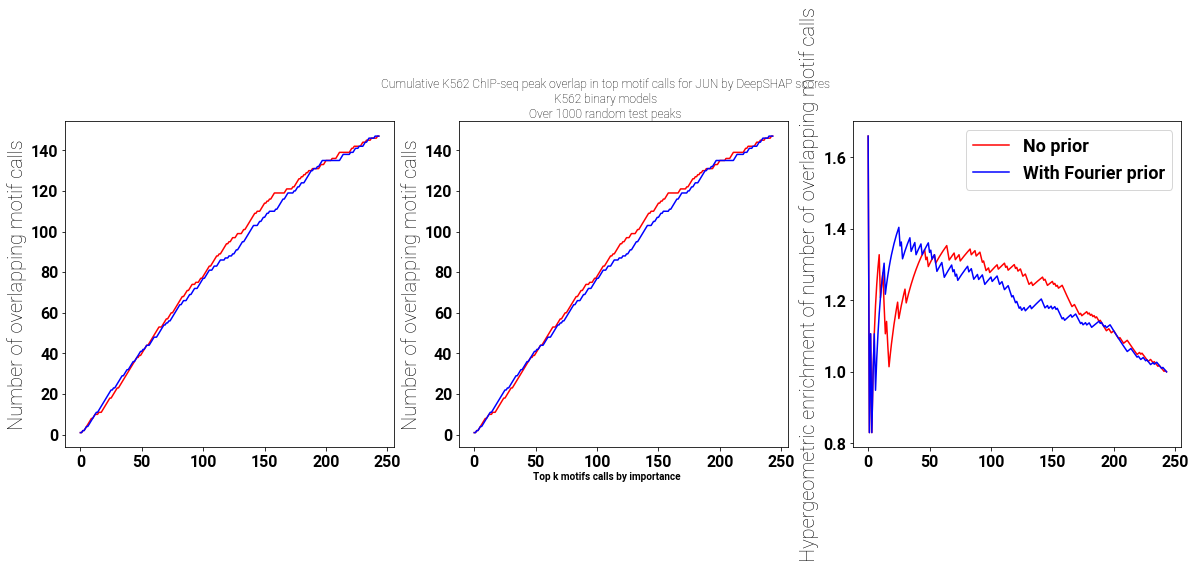

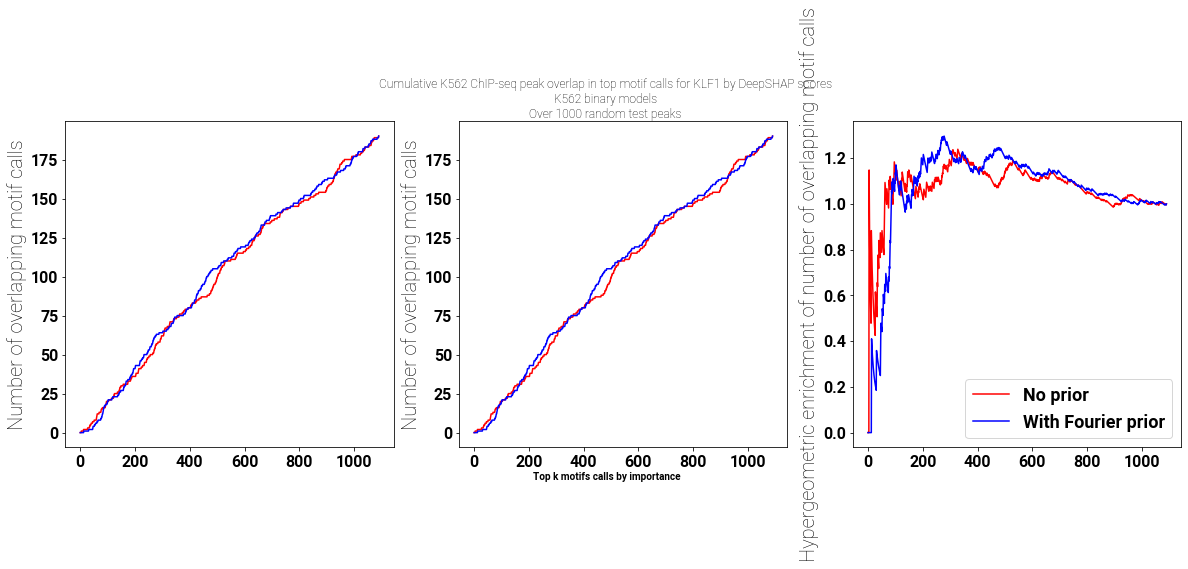

In [42]:
for i in range(len(tf_names)):
    top_limit = 10000
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    title = "Cumulative %s ChIP-seq peak overlap in top motif calls for %s by %s" % (condition_name, tf_names[i], imp_type)
    title += "\n%s %s models" % (condition_name, model_type)
    title += "\nOver %d random test peaks" % len(sample)
    fig.suptitle(title)
    ax[0].plot(np.cumsum(noprior_motif_overlap_masks[i][:top_limit]), label="No prior", color="red")
    ax[0].plot(np.cumsum(prior_motif_overlap_masks[i][:top_limit]), label="With Fourier prior", color="blue")
    ax[0].set_ylabel("Number of overlapping motif calls")
    ax[1].plot(np.cumsum(noprior_motif_overlap_masks[i]), label="No prior", color="red")
    ax[1].plot(np.cumsum(prior_motif_overlap_masks[i]), label="With Fourier prior", color="blue")
    ax[1].set_ylabel("Number of overlapping motif calls")
    ax[2].plot(noprior_motif_overlap_cdfs[i], label="No prior", color="red")
    ax[2].plot(prior_motif_overlap_cdfs[i], label="With Fourier prior", color="blue")
    ax[2].set_ylabel("Hypergeometric enrichment of number of overlapping motif calls")
    fig.text(0.45, 0.05, "Top k motifs calls by importance")
    plt.legend()

In [43]:
noprior_prs, prior_prs = [], []
for i in range(len(tf_names)):
    noprior_prs.append(
        sklearn.metrics.precision_recall_curve(
            noprior_motif_overlap_masks[i].astype(int),
            np.flip(np.arange(len(noprior_motif_overlap_masks[i]))) / len(noprior_motif_overlap_masks[i])
        )
    )
    prior_prs.append(
        sklearn.metrics.precision_recall_curve(
            prior_motif_overlap_masks[i].astype(int),
            np.flip(np.arange(len(prior_motif_overlap_masks[i]))) / len(prior_motif_overlap_masks[i])
        )
    )

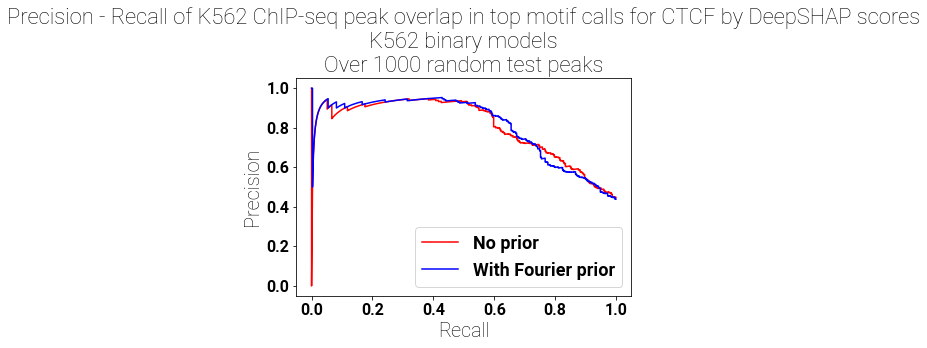

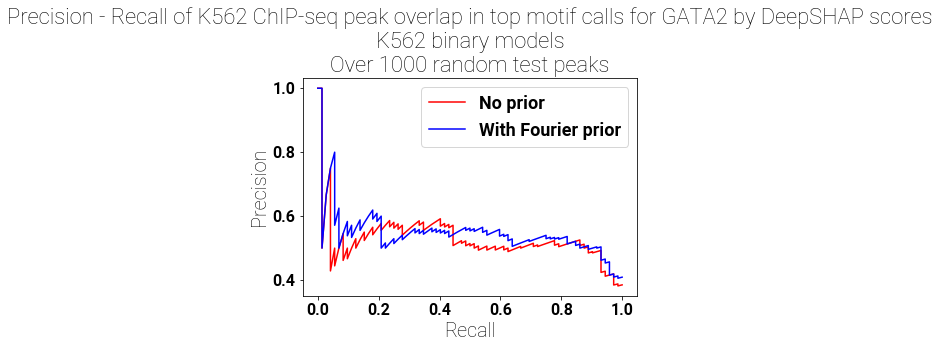

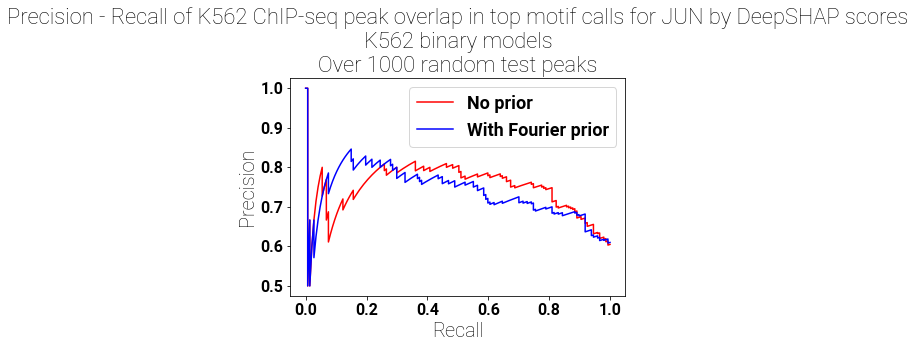

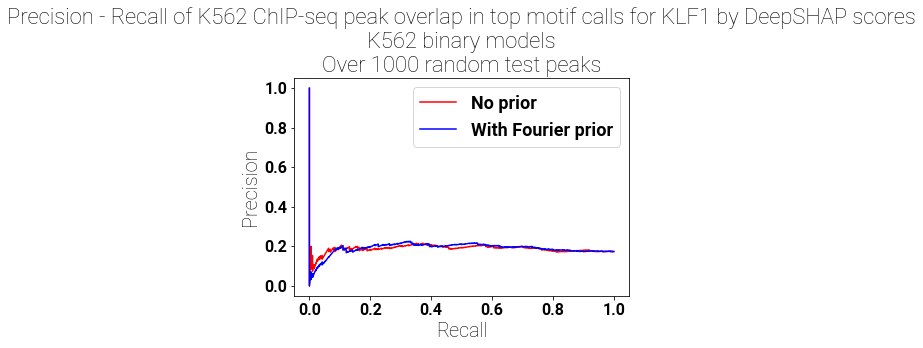

In [44]:
for i in range(len(tf_names)):
    plt.figure()
    title = "Precision - Recall of %s ChIP-seq peak overlap in top motif calls for %s by %s" % (condition_name, tf_names[i], imp_type)
    title += "\n%s %s models" % (condition_name, model_type)
    title += "\nOver %d random test peaks" % len(sample)
    plt.title(title)
    plt.plot(noprior_prs[i][1], noprior_prs[i][0], color="red", label="No prior")
    plt.plot(prior_prs[i][1], prior_prs[i][0], color="blue", label="With Fourier prior")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()